In [1]:
BATCH_SIZE   = 30
INPUT_DIM    = 784
HIDDEN_DIM   = 1024
LATENT_DIM   = 8
LATENT_STDEV = 10
EPOCHS       = 100

In [2]:
categorical_list = [10]
len(categorical_list)

1

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
import sys
import numpy as np
import scipy.misc
import os
os.environ.setdefault('CUDA_VISIBLE_DEVICES','0')

'0'

In [5]:
def linear(input, output_dim, scope=None, stddev=0.01):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

In [6]:
def encoder(images):
    output = tf.convert_to_tensor(images)
    output = tf.nn.relu(linear(output, HIDDEN_DIM, scope='e_layer1', stddev=0.01))
    output = tf.nn.relu(linear(output, HIDDEN_DIM, scope='e_layer2', stddev=0.01))
    return linear(output, LATENT_DIM, scope='e_layer3', stddev=0.01)

def decoder(latent_vars,y_label,reuse = False):
    if reuse:
            tf.get_variable_scope().reuse_variables()
    output = tf.convert_to_tensor(latent_vars)
    print (output.get_shape())
    output = tf.concat([output,y_label], 1)
    print (output.get_shape())
    output = tf.nn.relu(linear(output, HIDDEN_DIM, scope='d_layer1', stddev=0.01))
    output = tf.nn.relu(linear(output, HIDDEN_DIM, scope='d_layer2', stddev=0.01))
    return   tf.sigmoid(linear(output, INPUT_DIM, scope='d_layer3', stddev=0.01))

def discriminator(inputs,reuse = False):
    if reuse:
            tf.get_variable_scope().reuse_variables()
    output = tf.convert_to_tensor(inputs)
    output = tf.nn.relu(linear(output, HIDDEN_DIM, scope='dis_layer1', stddev=0.01))
    output = tf.nn.relu(linear(output, HIDDEN_DIM, scope='dis_layer2', stddev=0.01))
    return tf.sigmoid(linear(output, 1, scope='dis_layer3', stddev=0.01))

In [7]:
def noise(n_samples):
    batch_z = np.random.uniform(-1, 1, [n_samples,LATENT_DIM]).astype(np.float32)
    return batch_z

In [8]:
batch_size = 30
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

latents = encoder(x)
reconstructions = decoder(latents,y_)
#noise_image = decoder(noise(batch_size),y_,reuse = True)
#pred_image = decoder(noise(batch_size),reuse = True)
# Encoder objective:  push D(latents) to one...
with tf.variable_scope('latent_score') as scope:
    tf.VariableScope.reuse =None
    latent_score = discriminator(latents,reuse = False)

reg_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(latent_score),logits = latent_score))
true_noise_score = discriminator(noise(batch_size),reuse = True)
# ... and minimize reconstruction error
reconst_cost = tf.reduce_mean(tf.squared_difference(reconstructions,x))

# this seems to be an important hyperparam, maybe try playing with it more.
full_enc_cost = 100*reconst_cost + reg_cost

# Decoder objective: minimize reconstruction loss
dec_cost = reconst_cost

# Discrim objective: push D(latents) to zero, D(noise) to one
discrim_cost  =tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(latent_score),logits = latent_score))
discrim_cost +=tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(true_noise_score),logits = true_noise_score))

t_vars = tf.trainable_variables()
enc_params  = [var for var in t_vars if 'e_' in var.name]
dec_params  = [var for var in t_vars if 'd_' in var.name]                             
discrim_params = [var for var in t_vars if 'dis_' in var.name]                              

e_optim = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(full_enc_cost, var_list=enc_params)
d_optim = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(dec_cost, var_list=dec_params)
dis_optim = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(discrim_cost, var_list=discrim_params)

(?, 8)
(?, 18)


In [9]:
#optim = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss) 
session_conf = tf.ConfigProto(gpu_options =tf.GPUOptions(per_process_gpu_memory_fraction=0.7),
                                  allow_soft_placement=True,
                                  log_device_placement=False)

sess = tf.InteractiveSession(config=session_conf)
# Train

tf.initialize_all_variables().run()
for step in range(300):
    batch_xs, batch_ys = mnist.train.next_batch(30)
    _,_,_ = sess.run([e_optim,d_optim,dis_optim], feed_dict={x: batch_xs,y_:batch_ys})
    reconstructions_, latents_ = sess.run([reconstructions,latents],
                                                   feed_dict={x: batch_xs,y_:batch_ys})


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [10]:
batch_xs, batch_ys = mnist.test.next_batch(30)
test_y = [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]]

In [11]:
test_batch = batch_xs[-8:] 
test_image = []
for i in range(10):
    feed_dict={x: test_batch,y_:np.repeat([test_y[i]],8, axis=0)}
    samples_test= sess.run(reconstructions, feed_dict=feed_dict)
    test_image.append(samples_test)
test_image = np.array(test_image) 

In [12]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
def reshape_image(np_x,row,column):
    np_x = np_x.reshape((column,row,28,28))
    # split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
    np_x = np.concatenate(np.split(np_x,column,axis=0),axis=3)
    # split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
    np_x = np.concatenate(np.split(np_x,row,axis=1),axis=2)
    x_img = np.squeeze(np_x)
    return x_img

In [13]:
img_test = reshape_image(test_image,8,10)
img_org = reshape_image(test_batch,8,1)

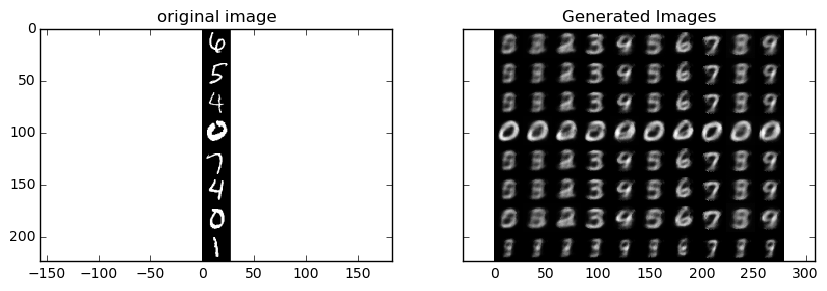

In [14]:
f,axarr=plt.subplots(1,2,figsize=(10,3),sharey=True)
# samples
axarr[0].imshow(img_org,cmap=plt.cm.gray,interpolation='none')
axarr[0].set_title('original image')
# reconstruction
axarr[1].imshow(img_test,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')